## Семинар 7: "Методы оптимизации"

ФИО: __Смирнов Егор Геннадьевич__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [76]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
                
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 50
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(g + param.grad ** 2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad


class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = 0.01
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.flag = True
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        sum_step = 0
        num_params = 0
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                if self.flag:
                    g.copy_(param.grad ** 2)
                else:
                    g.copy_(self.gamma * g + (1.0 - self.gamma) * param.grad ** 2)
                
                step = self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                
                sum_step = step.sum()
                num_params += step.numel()
                
                param -= step
                
        self.flag = False
        self.learning_rate = self.gamma * self.learning_rate + (1.0 - self.gamma) * sum_step / num_params


class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, beta1=0.9, beta2=0.999):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 10e-9
        self.m = [torch.zeros_like(param) for param in self.parameters]
        self.v = [torch.zeros_like(param) for param in self.parameters]
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for m, v, param in zip(self.m, self.v, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                v.copy_(self.beta2 * v + (1 - self.beta2) * param.grad ** 2)
                
                m_t = m / (1 - self.beta1)
                v_t = v / (1 - self.beta2)
                
                param -= self.learning_rate / torch.sqrt(v_t + self.eps) * m_t

In [52]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return torch.sin(x) * x**2 * y + torch.cos(y**2) * y

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colors = ["red", "blue", "yellow", "pink", "green", "black", "orange"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=0.01)
    
    points = []
    
    for i in range(20):
        p_z = F(x).item()
        #print(p_z)
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
4.668415916890483 2.5 1.5
4.568032310875087 2.530221803149728 1.5038905210806865
4.431897979544709 2.56537863793494 1.508376441586977
4.245525641684054 2.6064518281651288 1.5136684900018342
3.98765403184876 2.654668856653376 1.5200592303003977
3.626590809622747 2.7115786429734605 1.527958239086068
3.11432886168088 2.779151786618177 1.5379437960562121
2.376999454242176 2.8599118374055394 1.5508388418119503
1.2994097099875257 2.9570999796212183 1.5678214422136352
-0.2994031747309229 3.074860538711428 1.5905804099406418
-2.701947076141035 3.218388850850496 1.6215174880549978
-6.333424818065346 3.3938586428053616 1.6639563222544063
-11.767864638369609 3.6076424490349734 1.722189873018897
-19.561609511204665 3.863719964178802 1.8008868121140436
-29.643207248966 4.15744356758054 1.9029300261790647
-40.31479927492283 4.465225926528234 2.025292223438067
-48.563061626550216 4.739390423830152 2.1571354281445494
-53.18251811224959 4.930704559547802 2.289361101863351
-56.171928298703186 5.0305

In [10]:
R = 2
N = 21

space = np.linspace(R, -R, N)
X, Y = np.meshgrid(space, space)
Z = F(np.array([X.flatten(), Y.flatten()]).T).reshape(N, N)

TypeError: sin(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

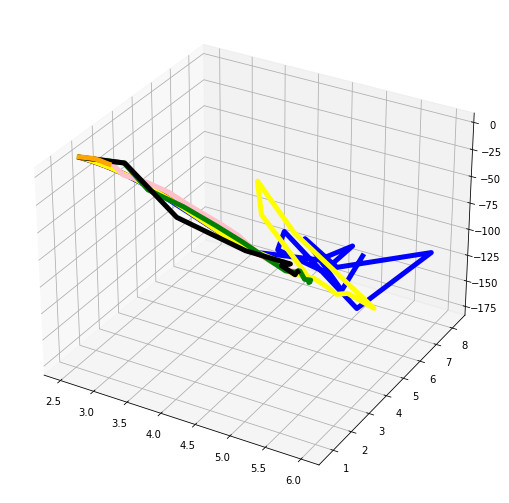

In [53]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

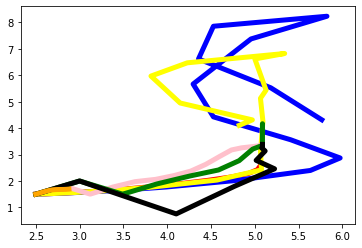

In [54]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [55]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return x**2 + y**2

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colors = ["red", "blue", "yellow", "pink", "green", "black", "orange"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=0.01)
    
    points = []
    
    for i in range(20):
        p_z = F(x).item()
        #print(p_z)
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
8.5 2.5 1.5
8.163400000000001 2.45 1.47
7.840129360000001 2.4010000000000002 1.4405999999999999
7.529660237344 2.35298 1.4117879999999998
7.231485691945178 2.3059204 1.3835522399999998
6.9451188585441495 2.2598019920000003 1.3558811951999998
6.670092151745801 2.2146059521600003 1.3287635712959998
6.405956502536667 2.1703138331168 1.3021882998700798
6.152280625036214 2.126907556454464 1.2761445338726782
5.90865031228478 2.0843694053253747 1.2506216431952246
5.674667759918303 2.0426820172188673 1.22560921033132
5.449950916625538 2.00182837687449 1.2010970261246936
5.234132860327167 1.9617918093370001 1.1770750856021996
5.026861199058211 1.9225559731502602 1.1535335838901557
4.827797495575505 1.8841048536872549 1.1304629122123526
4.636616714750716 1.8464227566135099 1.1078536539681056
4.4530066928465875 1.8094943014812397 1.0856965808887435
4.2766676278098625 1.7733044154516149 1.0639826492709687
4.107311589748592 1.7378383271425826 1.0427029962855494
3.9446620507945482 1.703081560599

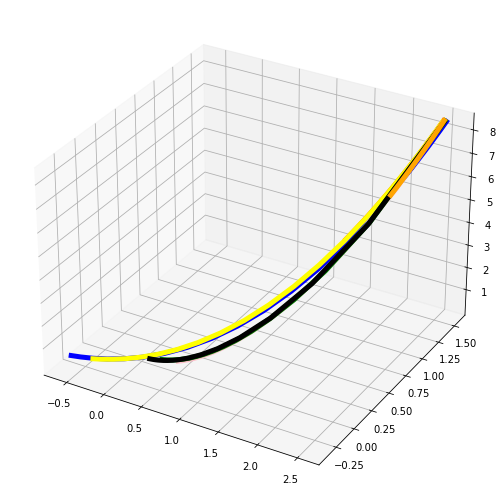

In [56]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

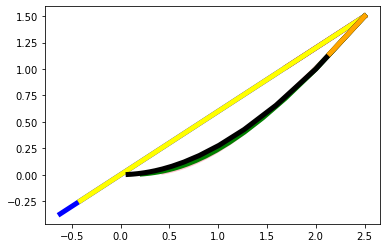

In [57]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [58]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    
    x, y = x[:, 0], x[:, 1]
    
    return torch.sin(x) * x**2 + torch.sin(y) * y**2

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colors = ["red", "blue", "yellow", "pink", "green", "black", "orange"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=0.01)
    
    points = []
    
    for i in range(20):
        p_z = F(x).item()
        #print(p_z)
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
5.98481462050885 2.5 1.5
5.842870139911936 2.5201478687664856 1.4684835633643551
5.692044433883103 2.542439974380342 1.4370650072789342
5.5304603945936375 2.5671447619306282 1.4058267943983263
5.355546872625051 2.594571002644757 1.3748463813250709
5.163836040629929 2.6250746753423426 1.3441954640621392
4.950700679486109 2.6590669606537367 1.3139394092803076
4.7100121249203895 2.6970233896420726 1.2841368714853136
4.433695293281769 2.7394940590871233 1.2548395881401586
4.111154212031998 2.787114572891539 1.2260923382922906
3.7285430680261147 2.840616904263066 1.197933045494056
3.267870866113597 2.9008385540737938 1.1703930028208887
2.705966039822025 2.968726988329952 1.1434971964644518
2.0134159147530584 3.0453340612363906 1.117264704477012
1.15377652362174 3.1317915925302184 1.0917091484753765
0.08367859029094216 3.229254179695926 1.0668391781637045
-1.2450167155723402 3.3387889651401386 1.0426589711031067
-2.879191716824322 3.4611864259386924 1.0191687329768027
-4.852346234542219 

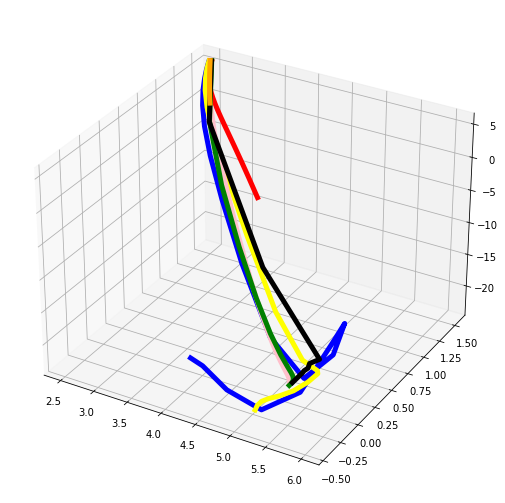

In [59]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

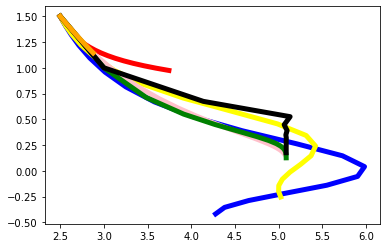

In [60]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [61]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    
    x, y = x[:, 0], x[:, 1]
    
    return torch.sin(x ** 2) * x**2 + torch.sin(y**2) * y**2

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colors = ["red", "blue", "yellow", "pink", "green", "black", "orange"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=0.01)
    
    points = []
    
    for i in range(20):
        p_z = F(x).item()
        #print(p_z)
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
1.5432945895755925 2.5 1.5
-3.0684377205788853 2.1893310176322216 1.5190595236271474
-3.1750703724773506 2.216039161454947 1.5436602193608446
-3.2951014937738803 2.216582114362237 1.575809802743496
-3.5077948163555823 2.216569210912101 1.61842708414426
-3.895414487498419 2.2165695281575934 1.6757595223660873
-4.611492034686642 2.2165695203639415 1.75372384884703
-5.883449218258125 2.2165695205554092 1.8590470568770512
-7.743324648369699 2.2165695205507054 1.9927454758803005
-9.274200444314488 2.216569520550821 2.12901517520771
-9.62262517403407 2.2165695205508182 2.205403243890847
-9.628939469994688 2.2165695205508182 2.216647236277693
-9.628939779235967 2.2165695205508182 2.216567601958605
-9.628939779424424 2.2165695205508182 2.216569567679359
-9.628939779424538 2.2165695205508182 2.2165695193930035
-9.628939779424538 2.2165695205508182 2.216569520579262
-9.628939779424538 2.2165695205508182 2.2165695205501192
-9.628939779424538 2.2165695205508182 2.216569520550835
-9.62893977942

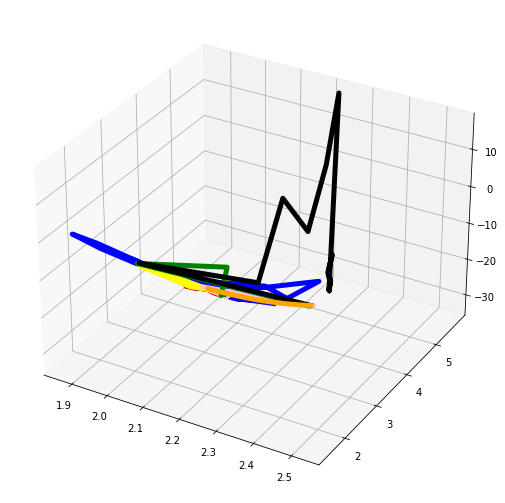

In [62]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

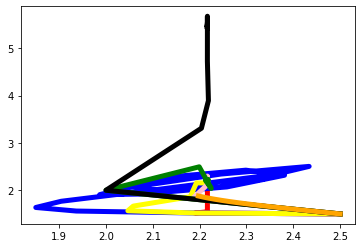

In [63]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

Для Adadelta нужно, как я понял, ставить изначально маленький lr (который потом меняется) и тогда делать много шагов, либо сделать побольше изналчальный lr.

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [26]:
# %load train_utils.py
import numpy as np
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

In [27]:
def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=True):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            optimizer.step( lambda: loss(prediction, y))
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, optimizer, ravel_init=True,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = optimizer(network.parameters(), learning_rate=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [75]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-30 19:01:14--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Распознаётся www.di.ens.fr (www.di.ens.fr)… 129.199.99.14
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [переход]
--2021-03-30 19:01:15--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [application/x-gzip]
Сохранение в: «MNIST.tar.gz»

MNIST.tar.gz            [               <=>  ]  33,20M  2,70MB/s    за 12s     

2021-03-30 19:01:27 (2,83 MB/s) - «MNIST.tar.gz» сохранён [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MN

In [79]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch 9... (Train/Test) NLL: 0.087/0.188	Accuracy: 0.975/0.962


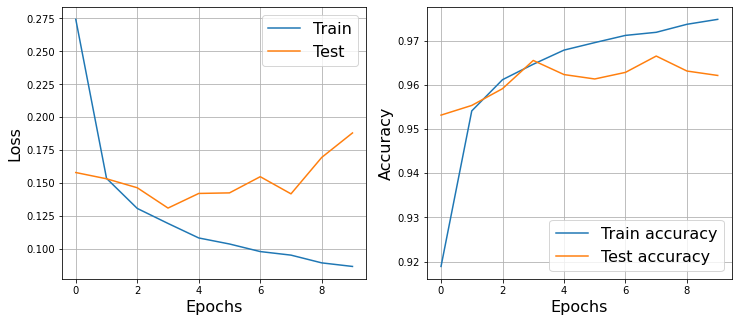

In [80]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adam_tr_loss, adam_ts_loss, adam_tr_ac, adam_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, Adam)

Epoch 9... (Train/Test) NLL: 0.675/0.678	Accuracy: 0.761/0.770


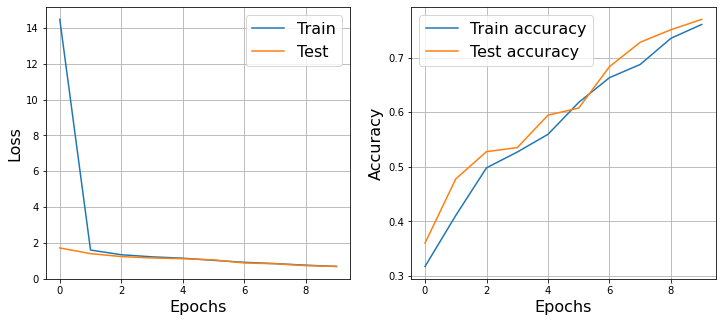

In [81]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adagrad_tr_loss, adagrad_ts_loss, adagrad_tr_ac, adagrad_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, Adagrad)

Epoch 9... (Train/Test) NLL: 0.618/0.602	Accuracy: 0.823/0.824


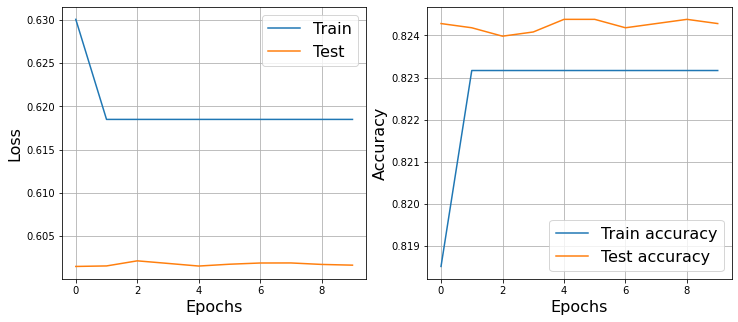

In [82]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adadelta_tr_loss, adadelta_ts_loss, adadelta_tr_ac, adadelta_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, Adadelta)

Epoch 9... (Train/Test) NLL: 0.067/0.084	Accuracy: 0.980/0.973


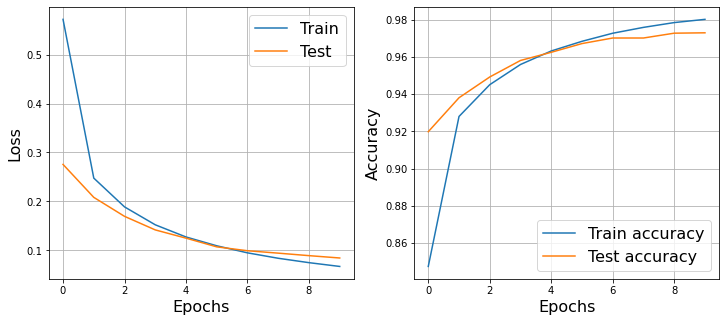

In [83]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
sgd_tr_loss, sgd_ts_loss, sgd_tr_ac, sgd_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, SGD)

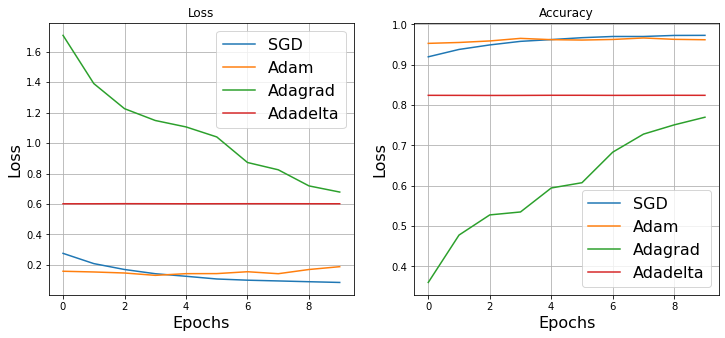

In [84]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(sgd_ts_loss, label='SGD')
plt.plot(adam_ts_loss, label='Adam')
plt.plot(adagrad_ts_loss, label='Adagrad')
plt.plot(adadelta_ts_loss, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(sgd_ts_ac, label='SGD')
plt.plot(adam_ts_ac, label='Adam')
plt.plot(adagrad_ts_ac, label='Adagrad')
plt.plot(adadelta_ts_ac, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Adadelta дает не очень хорошее качество.. Для Adagrad, похоже, надо больше эпох на обучение

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [67]:
class ConvClassifier_new(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 32, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input 32 x 13 x 13
            nn.Conv2d(32, 64, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input 64 x 5 x 5
        )
        self.layer_exit = nn.Sequential(nn.Linear(64 * 5 * 5, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 9... (Train/Test) NLL: 0.051/0.066	Accuracy: 0.984/0.982


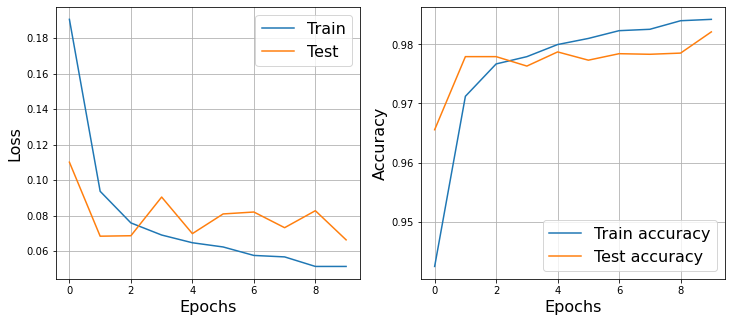

In [68]:
network = ConvClassifier_new(28)
adam_tr_loss, adam_ts_loss, adam_tr_ac, adam_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, optimizer=Adam, ravel_init=False)

Epoch 9... (Train/Test) NLL: 0.214/0.209	Accuracy: 0.942/0.947


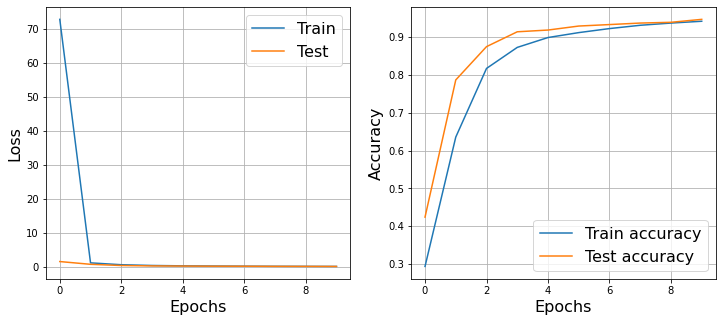

In [73]:
network = ConvClassifier_new(28)
adagrad_tr_loss, adagrad_ts_loss, adagrad_tr_ac, adagrad_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, optimizer=Adagrad, ravel_init=False)

Epoch 9... (Train/Test) NLL: 0.944/0.922	Accuracy: 0.811/0.825


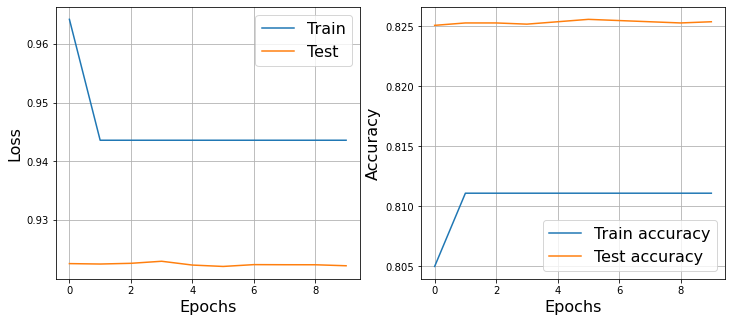

In [77]:
network = ConvClassifier_new(28)
adadelta_tr_loss, adadelta_ts_loss, adadelta_tr_ac, adadelta_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, optimizer=Adadelta, ravel_init=False)

Epoch 9... (Train/Test) NLL: 0.024/0.029	Accuracy: 0.993/0.990


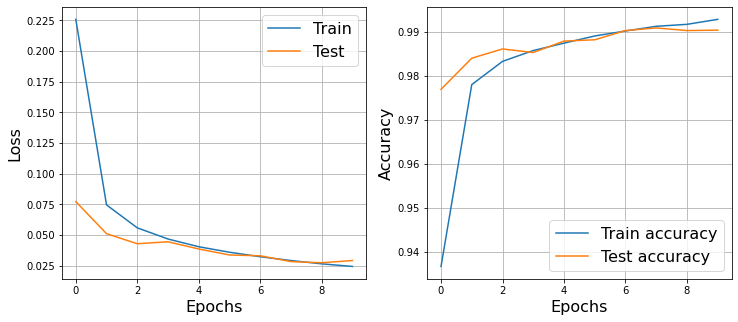

In [71]:
network = ConvClassifier_new(28)
sgd_tr_loss, sgd_ts_loss, sgd_tr_ac, sgd_ts_ac = train(network, train_loader, test_loader,
                               10, 0.01, optimizer=SGD, ravel_init=False)

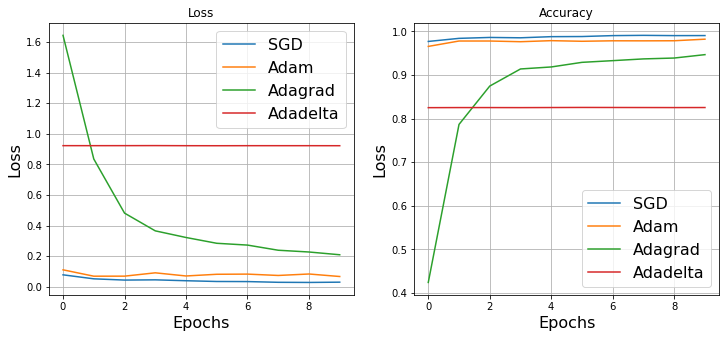

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(sgd_ts_loss, label='SGD')
plt.plot(adam_ts_loss, label='Adam')
plt.plot(adagrad_ts_loss, label='Adagrad')
plt.plot(adadelta_ts_loss, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(sgd_ts_ac, label='SGD')
plt.plot(adam_ts_ac, label='Adam')
plt.plot(adagrad_ts_ac, label='Adagrad')
plt.plot(adadelta_ts_ac, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Adadelta очень странная какая-то.. 